In [7]:
from PIL import Image
import numpy as np
import os, glob, itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import keras
from keras.models import Model
from keras.models import Sequential, model_from_json
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten
from keras.utils import multi_gpu_model
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.densenet import DenseNet201
#from keras.applications.inception_v3 import InceptionV3
import csv
import cv2 as cv

In [1]:
# Set up some global variables
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /device:GPU:0


In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
def parse_filenames(folder_name):
    files = glob.glob(os.path.join("./", folder_name, '*.tif'))
    return files

def get_data(filenames):
    # Read from CSV file, find abbreviated label (alabel) to full label (flabel) mapping
    csv_rows = []
    with open("PLANTS.csv", 'rtU') as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',', dialect=csv.excel_tab)
        for row in csvreader:
            csv_rows.append(row)

    for col_idx, col_title in enumerate(csv_rows[1]):
        if "PLPRMFL" in col_title:
            abbr_idx = col_idx
        if "PLFUELCT" in col_title:
            full_idx = col_idx
        if "Imagery Status" in col_title:
            imagery_idx = col_idx

    dict_alabel_flabel = {}
    dict_flabel_id = {}
    dict_alabel_id = {}
    dict_id_flabel = {}
    flabel_id_count = 0

    for row in csv_rows:
        if "YES" in row[imagery_idx]:
            if row[full_idx] not in dict_flabel_id:
                dict_flabel_id[row[full_idx]] = flabel_id_count
                dict_id_flabel[flabel_id_count] = row[full_idx]
                flabel_id_count += 1
            if row[abbr_idx] not in dict_alabel_flabel:
                dict_alabel_flabel[row[abbr_idx]] = row[full_idx]
                dict_alabel_id[row[abbr_idx]] = dict_flabel_id[row[full_idx]]
    print(dict_alabel_flabel)
    print(dict_flabel_id)

    m = len(filenames)
    X = np.zeros((m, 300, 300, 3))
    Y = np.zeros((m))
    dict_id_count = {}
    dict_flabel_count = {}

    for i in range(m):
        img = Image.open(filenames[i])
        X[i] = np.array(img)[:300,:300,:3]

        alabel = filenames[i].split('_')[-1][:-4]
        if (alabel not in dict_alabel_flabel):
            print("WARNING: unseen a-label found in filename.")
        Y[i] = int(dict_alabel_id[alabel])
        if (Y[i] not in dict_id_count):
            dict_id_count[Y[i]] = 0
        dict_id_count[Y[i]] += 1
        dict_flabel_count[dict_id_flabel[Y[i]]] = dict_id_count[Y[i]]

    print(X.shape)
    print(dict_id_count)
    print(dict_flabel_count)
    print(sorted(((v,k) for k,v in dict_flabel_count.items()), reverse=True))
    print(np.histogram(Y))
    return X, Y, dict_id_flabel

def resize_image(X, size):
    X_new = np.zeros((X.shape[0], *size, 3))
    for i in range(X.shape[0]):
        X_new[i, :, :, :] = cv.resize(X[i, :, :, :], 
                                      size, interpolation=cv.INTER_LINEAR)
    return X_new

def plot_history(history):
    '''
    Plots train and val loss and accuracy given history. From: history = model.fit(...)
    '''
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]

    if len(loss_list) == 0:
        print('Loss is missing in history')
        return

    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))

    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    '''
    :param cm: a confusion matrix output from sklearn func, which takes on actual label and prediction
    :param classes: a list of all the labels
    :param normalize: if True, performs row normalization
    :param title: title of the plot
    :param cmap: color choices
    '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('Power Plant Classification Confusion Matrix.png')

In [6]:
np.random.seed(7)

# Load images
X_raw, Y_raw, dict_id_flabel = get_data(parse_filenames(folder_name='uspp_naip_resized'))

# Resize images
#X = resize_image(X_raw, size=(300, 300))
X = X_raw

# Convert labels into one-hot-encoding format
encoder = LabelBinarizer()
Y = encoder.fit_transform(Y_raw)

# Split into train, dev, and test set
x_traindev, x_test, y_traindev, y_test = train_test_split(X, Y,
                                                          test_size=0.1,
                                                          shuffle=True)
x_train, x_dev, y_train, y_dev = train_test_split(x_traindev, y_traindev,
                                                          test_size=0.1,
                                                          shuffle=True)

/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 'U' mode is deprecated
  


{'COG': 'COAL', 'BLQ': 'BIOMASS', 'DFO': 'OIL', 'BIT': 'COAL', 'NG': 'GAS', 'WH': 'OTHF', 'WAT': 'HYDRO', 'NUC': 'NUCLEAR', 'WDS': 'BIOMASS', 'SUB': 'COAL', 'OBS': 'BIOMASS', 'LFG': 'BIOMASS', 'SUN': 'SOLAR', '': '', 'WND': 'WIND', 'OTH': 'OTHF', 'GEO': 'GEOTHERMAL', 'OG': 'OFSL', 'PUR': 'OTHF', 'OBG': 'BIOMASS', 'MSW': 'BIOMASS', 'PRG': 'OTHF', 'MWH': 'OTHF', 'AB': 'BIOMASS', 'KER': 'OIL', 'RFO': 'OIL', 'PC': 'OIL', 'BFG': 'OFSL', 'SGC': 'COAL', 'LIG': 'COAL', 'WC': 'COAL', 'SLW': 'BIOMASS', 'WDL': 'BIOMASS'}
{'COAL': 0, 'BIOMASS': 1, 'OIL': 2, 'GAS': 3, 'OTHF': 4, 'HYDRO': 5, 'NUCLEAR': 6, 'SOLAR': 7, '': 8, 'WIND': 9, 'GEOTHERMAL': 10, 'OFSL': 11}
(4454, 300, 300, 3)
{5.0: 688, 9.0: 457, 2.0: 326, 8.0: 19, 7.0: 850, 3.0: 1160, 0.0: 357, 1.0: 427, 6.0: 46, 10.0: 59, 4.0: 53, 11.0: 12}
{'HYDRO': 688, 'WIND': 457, 'OIL': 326, '': 19, 'SOLAR': 850, 'GAS': 1160, 'COAL': 357, 'BIOMASS': 427, 'NUCLEAR': 46, 'GEOTHERMAL': 59, 'OTHF': 53, 'OFSL': 12}
[(1160, 'GAS'), (850, 'SOLAR'), (688, 'HY

## DenseNet Using Pre-trained Weights (Imagenet)

In [8]:
def run_densenet(x_train, y_train, x_dev, y_dev, epochs=50, batch_size=200):
    # Create base model:Inception V3
    M, H, W, C = x_train.shape
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(H, W, C))
    
    # Add modification in the last few layers
    x = base_model.output
    x = Flatten()(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(y_train.shape[1], activation='softmax')(x)
    
    # Create 'Model'
    model = Model(inputs=base_model.input, outputs=outputs)
    
    # Set trainable layers
    for layer in base_model.layers:
        layer.trainable = True
    
    # Use multiple GPUs
    #parallel_model = multi_gpu_model(model, gpus=8)
    
    # Define loss and optimizer
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    
    # Train the model
    history = model.fit(x_train, y_train,
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(x_dev, y_dev))
    return model, history

In [9]:
# Run the model
model, history = run_densenet(x_train, y_train, x_dev, y_dev, epochs=20, batch_size=20)

76398592/76391848 [==============================] - 5s 0us/step
Train on 3607 samples, validate on 401 samples
Epoch 1/20
3607/3607 [==============================] - 172s 48ms/step - loss: 11.6618 - categorical_accuracy: 0.2637 - val_loss: 13.2946 - val_categorical_accuracy: 0.1696
Epoch 2/20
3607/3607 [==============================] - 103s 29ms/step - loss: 12.0152 - categorical_accuracy: 0.2542 - val_loss: 12.0182 - val_categorical_accuracy: 0.2544
Epoch 3/20
3607/3607 [==============================] - 104s 29ms/step - loss: 12.7179 - categorical_accuracy: 0.2104 - val_loss: 13.5571 - val_categorical_accuracy: 0.1571
Epoch 4/20
3607/3607 [==============================] - 104s 29ms/step - loss: 12.4249 - categorical_accuracy: 0.2279 - val_loss: 12.0182 - val_categorical_accuracy: 0.2544
Epoch 5/20
3607/3607 [==============================] - 104s 29ms/step - loss: 12.8559 - categorical_accuracy: 0.2018 - val_loss: 12.2594 - val_categorical_accuracy: 0.2394
Epoch 6/20
3607/3607 [=

In [25]:
# Make prediction on test set
y_test_pred = parallel_model.predict(x_train)
pred_class = np.argmax(y_test_pred, axis=1)
label_class = np.argmax(y_test, axis=1)

print(y_test_pred[0:5])
print(pred_class[0:5])
print(label_class[0:5])

errors = np.where(pred_class != label_class)[0]
print("No of errors = {}/{}".format(len(errors), len(label_class)))

[[0.08283295 0.08690669 0.08457243 0.08956959 0.08269937 0.08279078
  0.07722911 0.08544233 0.08223895 0.08443808 0.07999129 0.08128846]
 [0.08283295 0.08690669 0.08457243 0.08956959 0.08269937 0.08279078
  0.07722911 0.08544233 0.08223895 0.08443808 0.07999129 0.08128846]
 [0.08283295 0.08690669 0.08457243 0.08956959 0.08269937 0.08279078
  0.07722911 0.08544233 0.08223895 0.08443808 0.07999129 0.08128846]
 [0.08283295 0.08690669 0.08457243 0.08956959 0.08269937 0.08279078
  0.07722911 0.08544233 0.08223895 0.08443808 0.07999129 0.08128846]
 [0.08283295 0.08690669 0.08457243 0.08956959 0.08269937 0.08279078
  0.07722911 0.08544233 0.08223895 0.08443808 0.07999129 0.08128846]]
[3 3 3 3 3]
[9 3 2 2 7]
No of errors = 1/446


/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


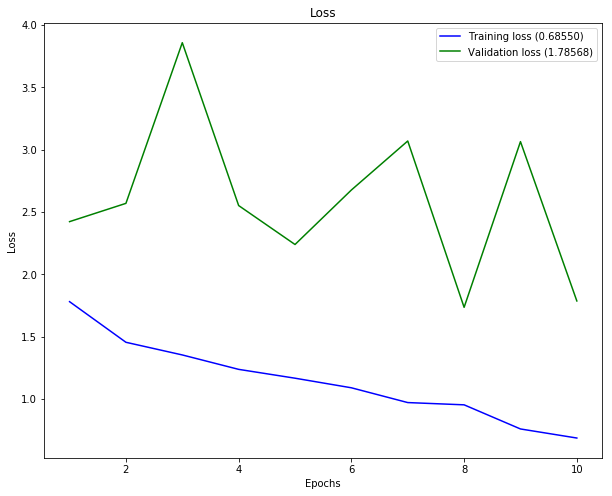

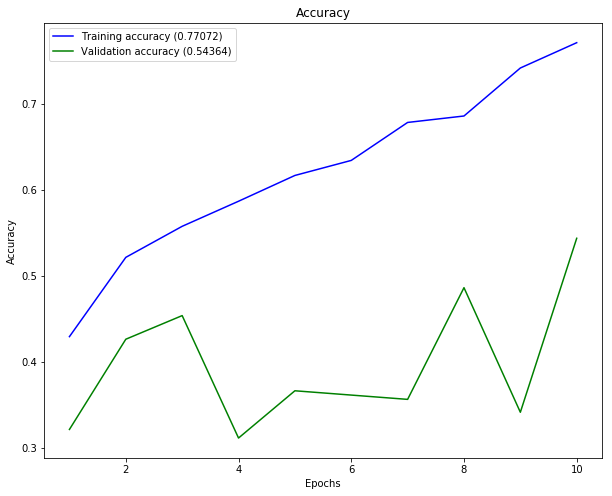

No of errors = 205/446


In [34]:
# Plot train and val accuracy & loss
plot_history(history)

# Make prediction on test set
y_test_pred = model.predict(x_test)
pred_class = np.argmax(y_test_pred, axis=1)
label_class = np.argmax(y_test, axis=1)

# Show confusion matrix
cnf_matrix = confusion_matrix(pred_class, label_class)
class_names = list(list(dict_id_flabel.values())) # list of all the labels
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')


errors = np.where(pred_class != label_class)[0]
print("No of errors = {}/{}".format(len(errors), len(label_class)))

In [11]:
# Save model and history
np.savetxt('resnet50_largeimg_imagenet_hist.csv', 
           np.c_[history.history['loss'], history.history['val_loss']],
           delimiter=',')
from keras.models import model_from_json
model_json = model.to_json()
with open("resnet50_largeimg_imagenet.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("resnet50_largeimg_imagenet.h5")
print("Saved model to disk")

NameError: name 'model' is not defined

In [7]:
# load json and create model
json_file = open('resnet50_largeimg_imagenet.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("resnet50_largeimg_imagenet.h5")
print("Loaded model from disk")

Loaded model from disk


In [8]:
# Run loaded model
loaded_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
history = loaded_model.fit(x_train, y_train,
                    epochs=20, batch_size=20,
                    validation_data=(x_dev, y_dev))

Train on 3607 samples, validate on 401 samples
Epoch 1/20
3607/3607 [==============================] - 231s 64ms/step - loss: 0.6996 - acc: 0.7741 - val_loss: 2.3843 - val_acc: 0.3791
Epoch 2/20
3607/3607 [==============================] - 201s 56ms/step - loss: 0.4735 - acc: 0.8450 - val_loss: 2.0635 - val_acc: 0.5411
Epoch 3/20
3607/3607 [==============================] - 202s 56ms/step - loss: 0.4379 - acc: 0.8550 - val_loss: 3.1047 - val_acc: 0.3865
Epoch 4/20
3607/3607 [==============================] - 202s 56ms/step - loss: 0.3940 - acc: 0.8736 - val_loss: 1.9605 - val_acc: 0.4888
Epoch 5/20
3607/3607 [==============================] - 202s 56ms/step - loss: 0.3182 - acc: 0.8969 - val_loss: 4.2618 - val_acc: 0.3641
Epoch 6/20
3607/3607 [==============================] - 202s 56ms/step - loss: 0.2590 - acc: 0.9138 - val_loss: 2.0697 - val_acc: 0.5062
Epoch 7/20
3607/3607 [==============================] - 202s 56ms/step - loss: 0.2020 - acc: 0.9368 - val_loss: 3.0677 - val_acc: 0

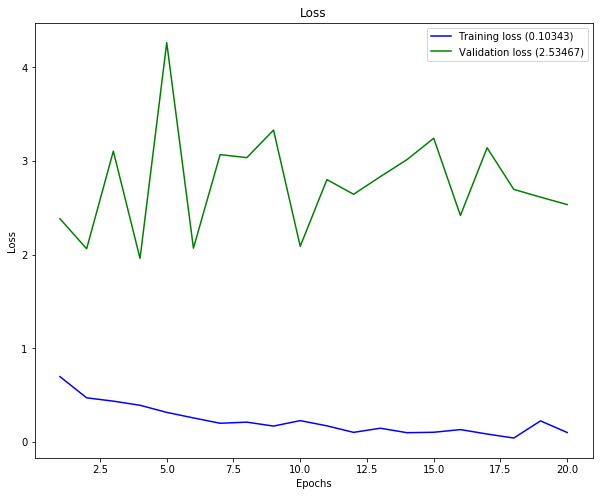

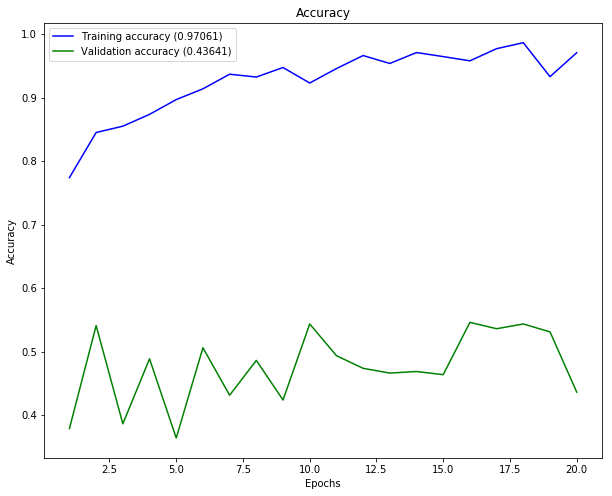

Confusion matrix
[[24 11  5 24  0  5  0  4  0  0  0  1]
 [ 4 15  8 39  1  1  1 10  0  8  1  0]
 [ 3  3  4 16  1  6  1  6  0  6  1  0]
 [ 1  3  6 23  0  1  0  1  0  1  2  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0]
 [ 4  3  4  7  1 65  0  9  1  3  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  5  0  5  0  2  0 41  0 13  0  0]
 [ 1  0  0  1  0  1  0  0  0  0  0  0]
 [ 0  1  1  1  0  1  0  2  0 22  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0]]
No of errors = 251/446


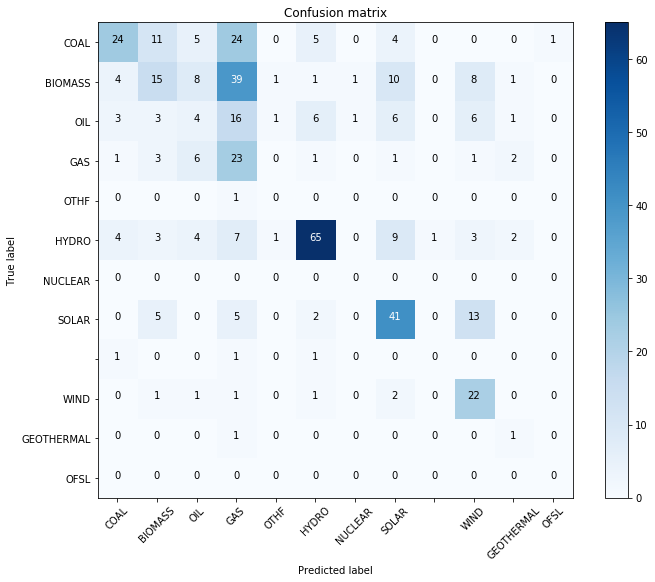

In [10]:
# Plot train and val accuracy & loss
plot_history(history)

# Make prediction on test set
y_test_pred = loaded_model.predict(x_test)
pred_class = np.argmax(y_test_pred, axis=1)
label_class = np.argmax(y_test, axis=1)

# Show confusion matrix
cnf_matrix = confusion_matrix(pred_class, label_class)
class_names = list(list(dict_id_flabel.values())) # list of all the labels
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')


errors = np.where(pred_class != label_class)[0]
print("No of errors = {}/{}".format(len(errors), len(label_class)))

In [13]:
def run_densenet(x_train, y_train, x_dev, y_dev, epochs=50, batch_size=200):
    # Create base model:Inception V3
    M, H, W, C = x_train.shape
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(H, W, C))
    
    # Add modification in the last few layers
    x = base_model.output
    x = Flatten()(x)
    
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(y_train.shape[1], activation='softmax')(x)
    
    # Create 'Model'
    model = Model(inputs=base_model.input, outputs=outputs)
    
    # Set trainable layers
    for layer in base_model.layers:
        layer.trainable = True
    
    # Use multiple GPUs
    #parallel_model = multi_gpu_model(model, gpus=8)
    
    # Define loss and optimizer
    opt = keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    
    # Train the model
    history = model.fit(x_train, y_train,
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(x_dev, y_dev))
    return model, history

In [ ]:
# Run the model
model, history = run_densenet(x_train, y_train, x_dev, y_dev, epochs=20, batch_size=20)

Train on 3607 samples, validate on 401 samples
Epoch 1/20
3607/3607 [==============================] - 168s 47ms/step - loss: 1.8237 - categorical_accuracy: 0.4308 - val_loss: 1.3009 - val_categorical_accuracy: 0.5835
Epoch 2/20
3607/3607 [==============================] - 98s 27ms/step - loss: 0.5813 - categorical_accuracy: 0.8278 - val_loss: 1.2211 - val_categorical_accuracy: 0.6185
Epoch 3/20
3607/3607 [==============================] - 99s 27ms/step - loss: 0.2130 - categorical_accuracy: 0.9504 - val_loss: 1.2157 - val_categorical_accuracy: 0.6284
Epoch 4/20
2900/3607 [=======================>......] - ETA: 18s - loss: 0.1083 - categorical_accuracy: 0.9821

Confusion matrix
[[  0   0   0   0  37   0   0   0   0   0   0   0]
 [  0   0   0   0  41   0   0   0   0   0   0   0]
 [  0   0   0   0  28   0   0   0   0   0   0   0]
 [  0   0   0   0 118   0   0   0   0   0   0   0]
 [  0   0   0   0   3   0   0   0   0   0   0   0]
 [  0   0   0   0  82   0   0   0   0   0   0   0]
 [  0   0   0   0   2   0   0   0   0   0   0   0]
 [  0   0   0   0  73   0   0   0   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   0  53   0   0   0   0   0   0   0]
 [  0   0   0   0   7   0   0   0   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0   0   0]]
No of errors = 443/446


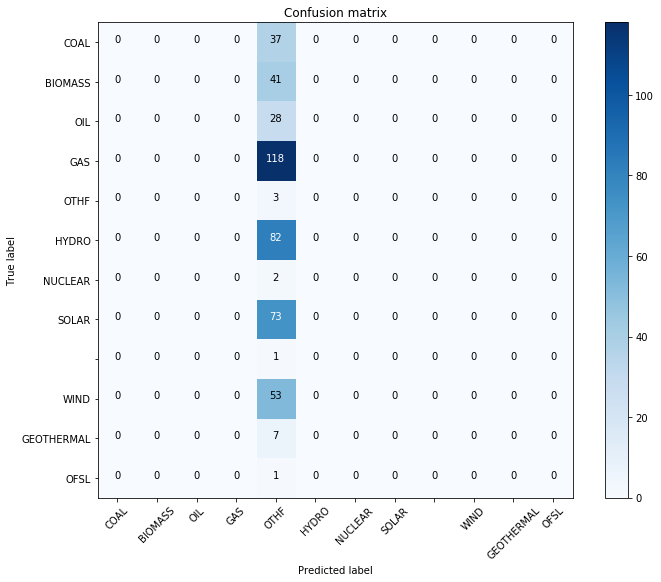

In [10]:
# Plot train and val accuracy & loss
#plot_history(history)

# Make prediction on test set
y_test_pred = parallel_model.predict(x_test)
pred_class = np.argmax(y_test_pred, axis=1)
label_class = np.argmax(y_test, axis=1)

# Show confusion matrix
cnf_matrix = confusion_matrix(label_class, pred_class)
class_names = list(list(dict_id_flabel.values())) # list of all the labels
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')


errors = np.where(pred_class != label_class)[0]
print("No of errors = {}/{}".format(len(errors), len(label_class)))

In [11]:
label_class[0:4]

array([9, 3, 2, 2])

In [13]:
y_test_pred[0:4]

array([[0.0689137 , 0.07503403, 0.07664672, 0.103681  , 0.11461211,
        0.08709159, 0.03992013, 0.10179986, 0.10163465, 0.10712378,
        0.06140637, 0.06213606],
       [0.0689137 , 0.07503403, 0.07664672, 0.103681  , 0.11461211,
        0.08709159, 0.03992013, 0.10179986, 0.10163465, 0.10712378,
        0.06140637, 0.06213606],
       [0.0689137 , 0.07503403, 0.07664672, 0.103681  , 0.11461211,
        0.08709159, 0.03992013, 0.10179986, 0.10163465, 0.10712378,
        0.06140637, 0.06213606],
       [0.0689137 , 0.07503403, 0.07664672, 0.103681  , 0.11461211,
        0.08709159, 0.03992013, 0.10179986, 0.10163465, 0.10712378,
        0.06140637, 0.06213606]], dtype=float32)

In [27]:
H = parallel_model.fit_generator(loaded_model(x_train, y_train, batch_size=100),
                                 samples_per_epoch=50, epochs=1)

TypeError: __call__() takes 2 positional arguments but 3 were given

In [22]:
parallel_model = multi_gpu_model(loaded_model, gpus=8)

# Define loss and optimizer
parallel_model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# Train the model
parallel_model.fit_generator(x_train, y_train,
                    epochs=1, batch_size=200)

TypeError: fit_generator() got an unexpected keyword argument 'batch_size'

Confusion matrix
[[  0   0   0   0  37   0   0   0   0   0   0   0]
 [  0   0   0   0  41   0   0   0   0   0   0   0]
 [  0   0   0   0  28   0   0   0   0   0   0   0]
 [  0   0   0   0 118   0   0   0   0   0   0   0]
 [  0   0   0   0   3   0   0   0   0   0   0   0]
 [  0   0   0   0  82   0   0   0   0   0   0   0]
 [  0   0   0   0   2   0   0   0   0   0   0   0]
 [  0   0   0   0  73   0   0   0   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   0  53   0   0   0   0   0   0   0]
 [  0   0   0   0   7   0   0   0   0   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0   0   0]]
No of errors = 443/446


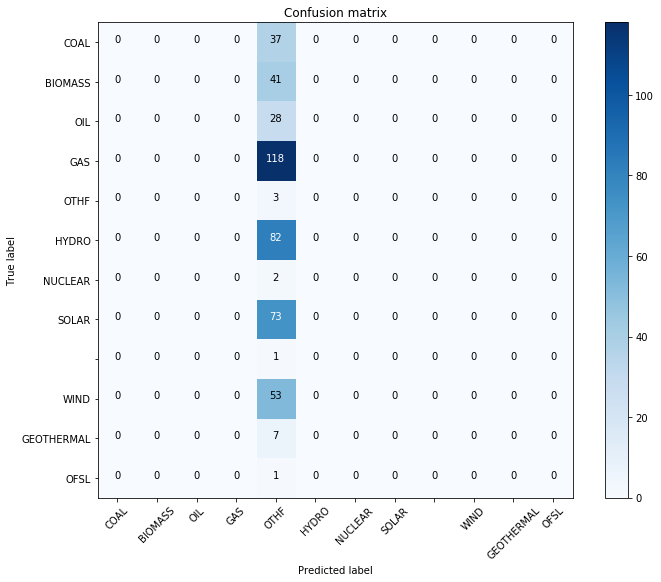

In [21]:
# Plot train and val accuracy & loss
#plot_history(history)

# Make prediction on test set
y_test_pred = parallel_model.predict(x_test)
pred_class = np.argmax(y_test_pred, axis=1)
label_class = np.argmax(y_test, axis=1)

# Show confusion matrix
cnf_matrix = confusion_matrix(label_class, pred_class)
class_names = list(list(dict_id_flabel.values())) # list of all the labels
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')


errors = np.where(pred_class != label_class)[0]
print("No of errors = {}/{}".format(len(errors), len(label_class)))

In [29]:
base_model = ResNet50(weights='imagenet')
base_model.trainable = True
image_model = Sequential()
image_model.add(Model(input = base_model.input,
                      output=base_model.get_layer('avg_pool').output))
image_model.add(Flatten())
feats = image_model.fit_generator(gen, len(images))

102858752/102853048 [==============================] - 6s 0us/step


/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("av...)`
  """


NameError: name 'image_generator' is not defined